In [1]:
import numpy as np
import pylab as mplot
import os
import pdb
from getdist import plots, MCSamples
import astropy.io.fits as pf

%pylab inline

Color = ['#d45e00', 'grey','k', 'purple']

font = {'size'   : 18}
# mplot.rc('font', **font)
# mplot.rc('text', usetex=True)
# mplot.rc('font', family='serif')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_nsample(filename):
    with open(filename,"r") as fi:
        for ln in fi:
            if ln.startswith("#nsample="):
                nsamples = int(ln[9:])
    return nsamples

def get_display_names(name_list, wcdm=False):
    display_dict = {'cosmological_parameters--omega_c':'\Omega_{\\rm c}', 
                    'cosmological_parameters--omega_b':'\Omega_b',
                    'cosmological_parameters--n_s':'n_s',
                    'cosmological_parameters--a_s':'a_s',
                    'cosmological_parameters--h0':'h_0',
                    'firecrown_two_point--ia_bias':'A_{IA}',
                    'firecrown_two_point--alphaz':'\\alpha_{z}',
                    'firecrown_two_point--source_0_mult_bias': 'm_{1}',
                    'firecrown_two_point--source_1_mult_bias': 'm_{2}',
                    'firecrown_two_point--source_2_mult_bias': 'm_{3}',
                    'firecrown_two_point--source_3_mult_bias': 'm_{4}',
                    'firecrown_two_point--source_4_mult_bias': 'm_{5}',
                    'firecrown_two_point--lens_0_bias': 'b_{1}',
                    'firecrown_two_point--lens_1_bias': 'b_{2}',
                    'firecrown_two_point--lens_2_bias': 'b_{3}',
                    'firecrown_two_point--lens_3_bias': 'b_{4}',
                    'firecrown_two_point--lens_4_bias': 'b_{5}',
                    'firecrown_two_point--lens_0_delta_z': '\Delta z_{l,1}',
                    'firecrown_two_point--lens_1_delta_z': '\Delta z_{l,2}',
                    'firecrown_two_point--lens_2_delta_z': '\Delta z_{l,3}',
                    'firecrown_two_point--lens_3_delta_z': '\Delta z_{l,4}',
                    'firecrown_two_point--lens_4_delta_z': '\Delta z_{l,5}',
                    'firecrown_two_point--source_0_delta_z': '\Delta z_{s,1}',
                    'firecrown_two_point--source_1_delta_z': '\Delta z_{s,2}',
                    'firecrown_two_point--source_2_delta_z': '\Delta z_{s,3}',
                    'firecrown_two_point--source_3_delta_z': '\Delta z_{s,4}',
                    'firecrown_two_point--source_4_delta_z': '\Delta z_{s,5}',
                    'cosmological_parameters--S_8':'S_{8}',
                    'cosmological_parameters--sigma_8':'\sigma_{8}',
                    'cosmological_parameters--omega_m':'\Omega_{m}',
                    'prior':'{\rm Pr}',
                    'like':'\mathcal{L}',
                    'post':'\mathcal{P}',
                    'weight':'{\rm weight}'}
    
    if wcdm==True:
        display_dict['cosmological_parameters--w'] = 'w_0'
        display_dict['cosmological_parameters--wa'] = 'w_a'
    
    display_names = []
    for ii in range(0,len(name_list)):
        if name_list[ii] in display_dict:
            display_names.append(display_dict[name_list[ii]])
        else:
            display_names.append('---')
    return display_names


def load_chain(file,verbose=False):
    import subprocess
    with open(file,'r') as f:
        first_line = f.readline()
    #a=first_line.split("\t") - this doesn't work for some 3x2 chains
    a=first_line.split()
    column_names = []
    for i in range(0,len(a)):
        if (i == 0):
            column_name = a[i][1:].lower()
        else:
            column_name = a[i].lower()
        
        if verbose: print("[%02d] %s"%(i,column_name))
        column_names.append(column_name)
        
    #Get ranges
    ranges = {}
    with open(file,'r') as f:
        line = ''
        current_prefix = ''
        in_values = False
        while not line.startswith('## END_OF_VALUES_INI'):
            line = f.readline()
            if (line.startswith('## START_OF_VALUES_INI')):
                    in_values = True
            if (in_values):
                if (line.startswith('## [')):
                    current_prefix = line[4:-2]
                elif (len(line) > 0):
                    temp = line.split()
                    if (len(temp) == 6):
                        param_name = current_prefix + '--' + temp[1]
                        min_val = float(temp[3])
                        max_val = float(temp[5]) 
                        ranges[param_name] = [min_val, max_val]
                        #print('param name = ', param_name)
                        #print("min val = ", min_val)
                        #print("max val = ", max_val)                 
    
    if verbose==True: print(subprocess.check_output(['tail', '-3', file]).decode('ascii').split('\n')[0].split('=')[1] )    
    nsamp = int(subprocess.check_output(['tail', '-3', file]).decode('ascii').split('\n')[0].split('=')[1] )
    chain  = np.loadtxt(file)
    weight = chain[-nsamp:,-1]
    chi2 = chain[-nsamp:,-5]
    
    #check for columns that contain nan - happens for Planck chain
    not_nan = np.where(np.isfinite(chain[0,:]))[0]
    chain = chain[:,not_nan]
    column_names = np.ndarray.tolist(np.array(column_names)[not_nan])    
    
    return chain, weight, nsamp, column_names, ranges

def get_samples(file,include_S8=True, wcdm=False):
    data, w, nsamp, column_names, ranges = load_chain(file, verbose = False)
    
    #Append S8
    if (include_S8):
        Om_index = np.where(np.array(column_names) == 'cosmological_parameters--omega_m')[0][0]
        sigma8_index = np.where(np.array(column_names) == 'cosmological_parameters--sigma_8')[0][0]
        sigma8 = data[:,sigma8_index]
        Om = data[:,Om_index]
        S8 = sigma8*(Om/0.3)**0.5
        data_with_S8 = np.vstack((data.transpose(),S8)).transpose()
        column_names.append('S8')
    
        display_names = get_display_names(column_names, wcdm=wcdm)    
        samples = MCSamples(samples=data_with_S8,weights=(w),
            names = column_names,
            labels = display_names,
            ranges = ranges)
    else:
        display_names = get_display_names(column_names, wcdm=wcdm)    
        samples = MCSamples(samples=data,weights=(w),
            names = column_names,
            labels = display_names,
            ranges = ranges)
    
    return samples


In [18]:
gauss_3x2pt = 'gaussian_sims_3x2pt.txt'
gauss_3x2pt_wcdm = 'gaussian_sims_3x2pt_wcdm.txt'

In [19]:
Samples = []

## NOTE: the order of name_list and file_list MUST MATCH!

name_list = np.array(['gauss_3x2pt'])
file_list = np.array([gauss_3x2pt])
print("num names = ", len(name_list))
print("num files = ", len(file_list))

for i in range(len(file_list)):
    print("")
    print(name_list[i])    
    samples = get_samples(file_list[i], wcdm=False)
    print(samples.getInlineLatex('cosmological_parameters--omega_m',limit=1))
    print(samples.getInlineLatex('cosmological_parameters--sigma_8',limit=1))
    print(samples.getInlineLatex('S8',limit=1))   
    
    Samples.append(samples)

num names =  1
num files =  1

gauss_3x2pt
Removed no burn in
\Omega_{m} = 0.276\pm 0.011
\sigma_{8} = 0.781\pm 0.016
--- = 0.7486\pm 0.0090


In [20]:
labels_lcdm = ['cosmological_parameters--omega_c', 
                    'cosmological_parameters--omega_b',
                    'cosmological_parameters--n_s',
                    'cosmological_parameters--a_s',
                    'cosmological_parameters--h0',
                    'firecrown_two_point--ia_bias',
                    'firecrown_two_point--alphaz',
                    'firecrown_two_point--source_0_mult_bias',
                    'firecrown_two_point--source_1_mult_bias',
                    'firecrown_two_point--source_2_mult_bias',
                    'firecrown_two_point--source_3_mult_bias',
                    'firecrown_two_point--source_4_mult_bias',
                    'firecrown_two_point--lens_0_bias',
                    'firecrown_two_point--lens_1_bias',
                    'firecrown_two_point--lens_2_bias',
                    'firecrown_two_point--lens_3_bias',
                    'firecrown_two_point--lens_4_bias',
                    'firecrown_two_point--lens_0_delta_z',
                    'firecrown_two_point--lens_1_delta_z',
                    'firecrown_two_point--lens_2_delta_z',
                    'firecrown_two_point--lens_3_delta_z',
                    'firecrown_two_point--lens_4_delta_z',
                    'firecrown_two_point--source_0_delta_z',
                    'firecrown_two_point--source_1_delta_z',
                    'firecrown_two_point--source_2_delta_z',
                    'firecrown_two_point--source_3_delta_z',
                    'firecrown_two_point--source_4_delta_z',
                    'cosmological_parameters--sigma_8',
                    'cosmological_parameters--omega_m' ]

labels_wcdm = labels_lcdm.copy()
labels_wcdm.append('cosmological_parameters--w')
labels_wcdm.append('cosmological_parameters--wa')


labels_lcdm_short = ['cosmological_parameters--omega_c', 
                    'cosmological_parameters--omega_b',
                    'cosmological_parameters--n_s',
                    'cosmological_parameters--a_s',
                    'cosmological_parameters--h0',
                    'cosmological_parameters--sigma_8',
                    'cosmological_parameters--omega_m' ]

labels_wcdm_short = labels_lcdm_short.copy()
labels_wcdm_short.append('cosmological_parameters--w')
labels_wcdm_short.append('cosmological_parameters--wa')

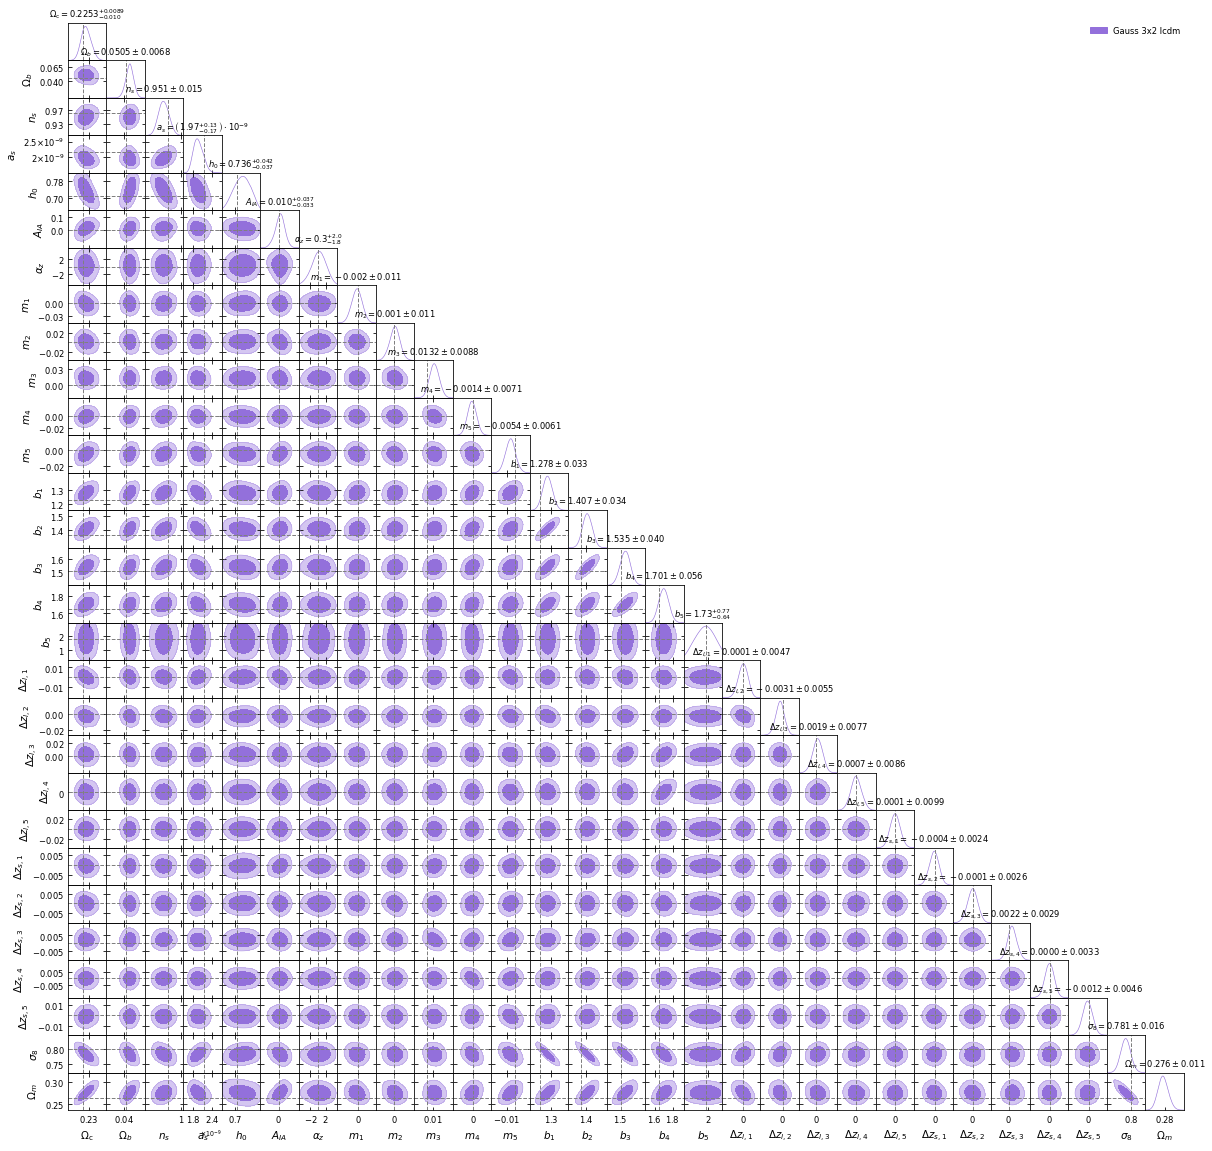

In [11]:
g = plots.getSubplotPlotter(width_inch=20)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize   = 14
g.settings.lab_fontsize    = 16
g.settings.legend_fontsize = 14


chains_to_plot = ['gauss_3x2pt']
samples_to_plot = [Samples[np.where(name_list == chain_name)[0][0]] for chain_name in chains_to_plot]

cs = ['mediumpurple','k','orange','teal']

g.triangle_plot(samples_to_plot,labels_lcdm,
          filled=[True,False,True,False], colors=cs, alphas=[1.0,1,1,0.8,1]
                , ls=['-','-', '-', '-'], lws=[1, 1,1,1], 
          legend_labels=["Gauss 3x2 lcdm"], title_limit=1,         
                legend_loc='upper right', contour_colors=cs)


X = [0.22,0.0448,0.963,2.16e-09,0.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.229,1.362,1.502,1.648,1.799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.22+0.0448]

for axi in range(len(X)-1):
    for ax in range(axi,len(X)): 
        g.subplots[ax,axi].axvline(X[axi], color='gray', ls='--',lw=1)

for axi in range(len(X)-1):
    for ax in range(0,axi+1): 
        g.subplots[axi+1,ax].axhline(X[axi+1], color='gray', ls='--',lw=1)


mplot.savefig('gauss_3x2_lcdm.pdf', bbox_inches='tight')

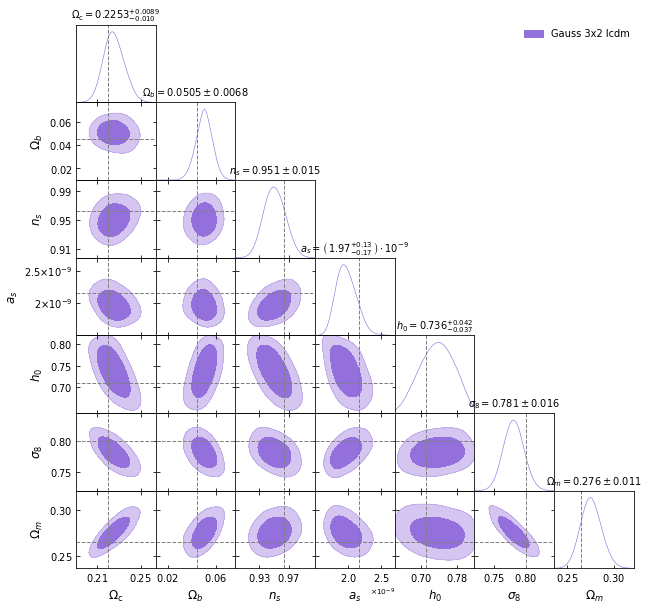

In [22]:
g = plots.getSubplotPlotter(width_inch=10)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize   = 14
g.settings.lab_fontsize    = 16
g.settings.legend_fontsize = 14


chains_to_plot = ['gauss_3x2pt']
samples_to_plot = [Samples[np.where(name_list == chain_name)[0][0]] for chain_name in chains_to_plot]

cs = ['mediumpurple','k','orange','teal']

g.triangle_plot(samples_to_plot,labels_lcdm_short,
          filled=[True,False,True,False], colors=cs, alphas=[1.0,1,1,0.8,1]
                , ls=['-','-', '-', '-'], lws=[1, 1,1,1], 
          legend_labels=["Gauss 3x2 lcdm"], title_limit=1,         
                legend_loc='upper right', contour_colors=cs)


X = [0.22,0.0448,0.963,2.16e-09,0.71,0.8,0.22+0.0448]

for axi in range(len(X)):
    for ax in range(axi,len(X)): 
        g.subplots[ax,axi].axvline(X[axi], color='gray', ls='--',lw=1)

for axi in range(len(X)-1):
    for ax in range(0,axi+1): 
        g.subplots[axi+1,ax].axhline(X[axi+1], color='gray', ls='--',lw=1)


mplot.savefig('gauss_3x2_lcdm_short.pdf', bbox_inches='tight')

In [23]:
Samples = []

## NOTE: the order of name_list and file_list MUST MATCH!

name_list = np.array(['gauss_3x2pt_wcdm'])
file_list = np.array([gauss_3x2pt_wcdm])
print("num names = ", len(name_list))
print("num files = ", len(file_list))

for i in range(len(file_list)):
    print("")
    print(name_list[i])    
    samples = get_samples(file_list[i], wcdm=True)
    print(samples.getInlineLatex('cosmological_parameters--omega_m',limit=1))
    print(samples.getInlineLatex('cosmological_parameters--sigma_8',limit=1))
    print(samples.getInlineLatex('S8',limit=1))   
    
    Samples.append(samples)

num names =  1
num files =  1

gauss_3x2pt_wcdm
Removed no burn in
\Omega_{m} = 0.270\pm 0.019
\sigma_{8} = 0.787^{+0.021}_{-0.024}
--- = 0.746\pm 0.011


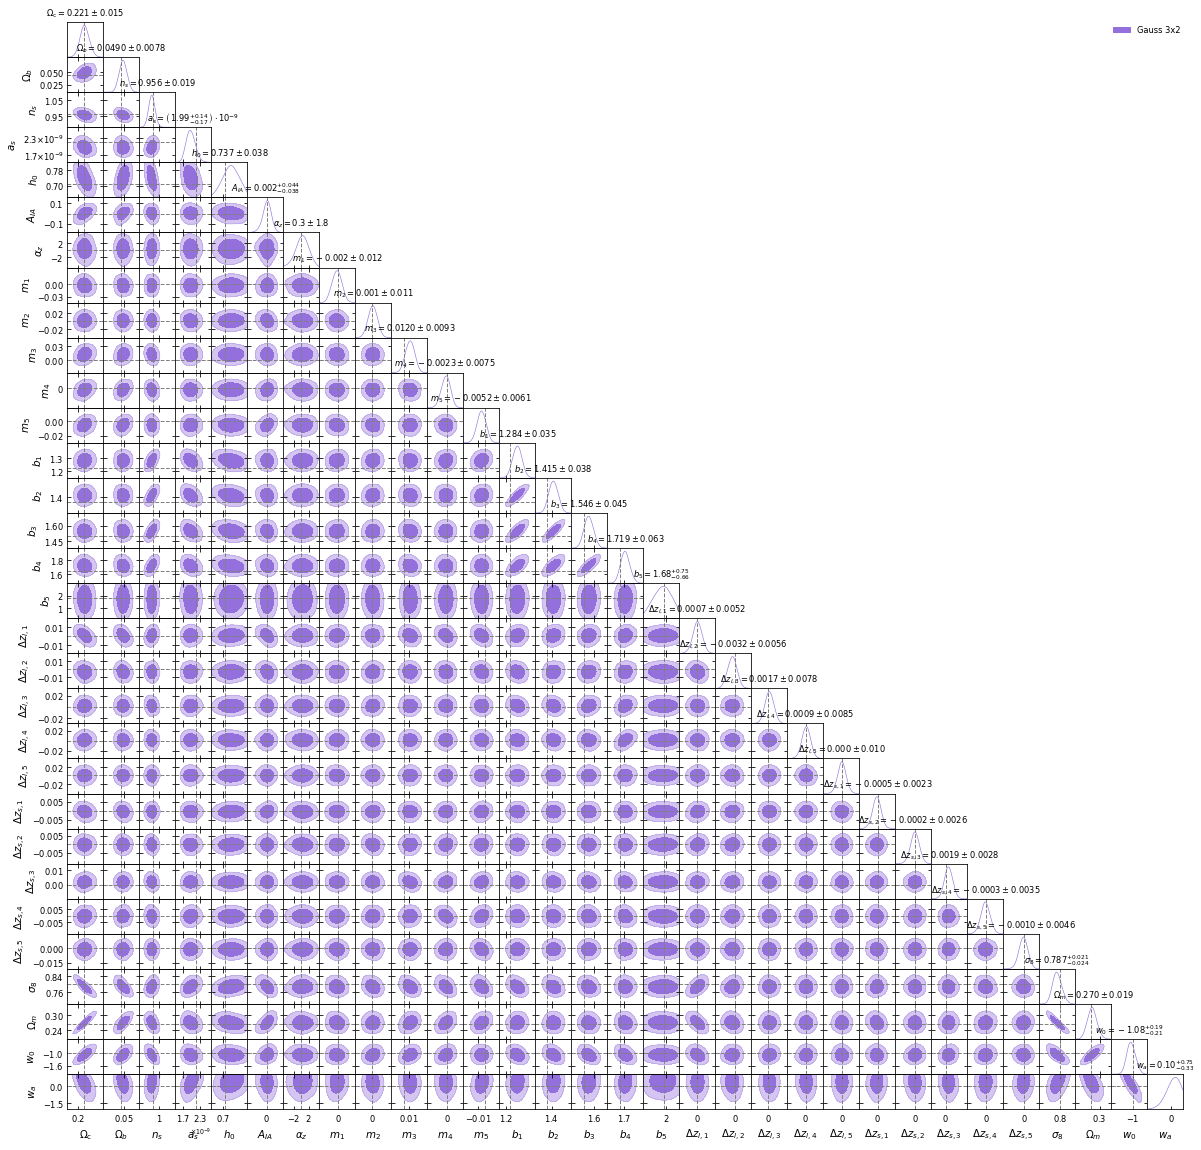

In [14]:
g = plots.getSubplotPlotter(width_inch=20)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize   = 14
g.settings.lab_fontsize    = 16
g.settings.legend_fontsize = 14


chains_to_plot = ['gauss_3x2pt_wcdm']
samples_to_plot = [Samples[np.where(name_list == chain_name)[0][0]] for chain_name in chains_to_plot]

cs = ['mediumpurple','k','orange','teal']
g.triangle_plot(samples_to_plot, labels_wcdm,
          filled=[True,False,True,False], colors=cs, alphas=[1.0,1,1,0.8,1], title_limit=1
                , ls=['-','-', '-', '-'], lws=[1, 1,1,1], 
          legend_labels=[  "Gauss 3x2" ],          
                legend_loc='upper right', contour_colors=cs)


X = [0.22,0.0448,0.963,2.16e-09,0.71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.229,1.362,1.502,1.648,1.799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.22+0.0448,-1.0, 0.0]

for axi in range(len(X)):
    for ax in range(axi,len(X)): 
        g.subplots[ax,axi].axvline(X[axi], color='gray', ls='--',lw=1)

for axi in range(len(X)-1):
    for ax in range(0,axi+1): 
        g.subplots[axi+1,ax].axhline(X[axi+1], color='gray', ls='--',lw=1)


mplot.savefig('gauss_3x2_wcdm.pdf', bbox_inches='tight')

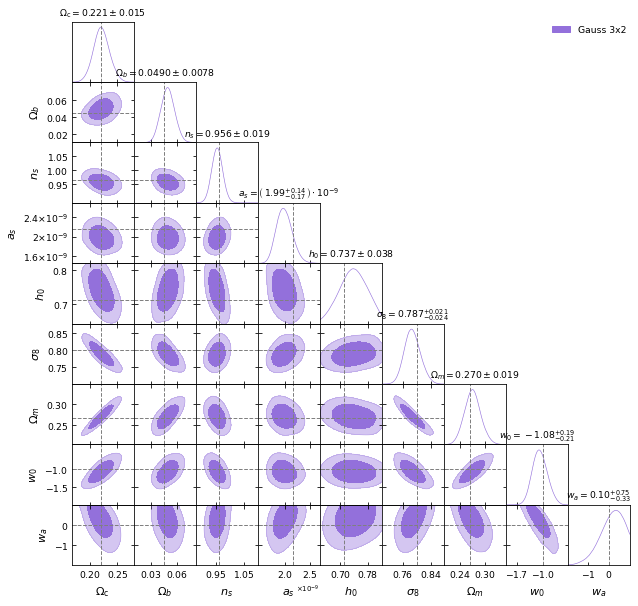

In [24]:
g = plots.getSubplotPlotter(width_inch=10)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize   = 14
g.settings.lab_fontsize    = 16
g.settings.legend_fontsize = 14


chains_to_plot = ['gauss_3x2pt_wcdm']
samples_to_plot = [Samples[np.where(name_list == chain_name)[0][0]] for chain_name in chains_to_plot]

cs = ['mediumpurple','k','orange','teal']
g.triangle_plot(samples_to_plot, labels_wcdm_short,
          filled=[True,False,True,False], colors=cs, alphas=[1.0,1,1,0.8,1], title_limit=1
                , ls=['-','-', '-', '-'], lws=[1, 1,1,1], 
          legend_labels=[  "Gauss 3x2"],          
                legend_loc='upper right', contour_colors=cs)


X = [0.22,0.0448,0.963,2.16e-09,0.71,0.8,0.22+0.0448,-1.0, 0.0]

for axi in range(len(X)):
    for ax in range(axi,len(X)): 
        g.subplots[ax,axi].axvline(X[axi], color='gray', ls='--',lw=1)

for axi in range(len(X)-1):
    for ax in range(0,axi+1): 
        g.subplots[axi+1,ax].axhline(X[axi+1], color='gray', ls='--',lw=1)


mplot.savefig('gauss_3x2_wcdm_short.pdf', bbox_inches='tight')


In [44]:
Samples = []

filename = 'Y1_3x2.txt'

data = np.loadtxt(filename)
print(len(data))
nsample = 300000

Om = data[-nsample:,0] 
sigma8 = data[-nsample:,1]
ns = data[-nsample:,2]
w0 = data[-nsample:,3]
wa = data[-nsample:,4]
Ob = data[-nsample:,5]
h0 = data[-nsample:,6]

samples = MCSamples(samples=np.c_[Om,sigma8,ns,w0,wa,Ob,h0],
        names = ['Om','sigma8','ns','w0','wa','Ob','h0'],
        labels = [r'\Omega_{m}','\sigma_{8}','n_{s}','w_{0}','w_{a}','\Omega_{b}','h_{0}'])

Samples.append(samples)

filename = 'gaussian_sims_3x2pt_wcdm.txt'

data = np.loadtxt(filename)
nsample = get_nsample(filename)

Om = data[-nsample:,-5] 
sigma8 = data[-nsample:,-6]
ns = data[-nsample:,2]
w0 = data[-nsample:,5]
wa = data[-nsample:,6]
Ob = data[-nsample:,1]
h0 = data[-nsample:,4]

w = data[-nsample:,-1]

samples = MCSamples(samples=np.c_[Om,sigma8,ns,w0,wa,Ob,h0],weights=(w),
        names = ['Om','sigma8','ns','w0','wa','Ob','h0'],
        labels = [r'\Omega_{m}','\sigma_{8}','n_{s}','w_{0}','w_{a}','\Omega_{b}','h_{0}'])

Samples.append(samples)

filename = 'chain_2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits.scales-ml_3x2pt_8_6_0.5_v0.40.ini.d3_w0wa_nla_realy3dat.txt'

data = np.loadtxt(filename)
nsample = get_nsample(filename)

Om = data[-nsample:,0] 
sigma8 = data[-nsample:,-7]
ns = data[-nsample:,3]
w0 = data[-nsample:,6]
wa = data[-nsample:,7]
Ob = data[-nsample:,2]
h0 = data[-nsample:,1]

w = data[-nsample:,-1]

samples = MCSamples(samples=np.c_[Om,sigma8,ns,w0,wa,Ob,h0],weights=(w),
        names = ['Om','sigma8','ns','w0','wa','Ob','h0'],
        labels = [r'\Omega_{m}','\sigma_{8}','n_{s}','w_{0}','w_{a}','\Omega_{b}','h_{0}'])

Samples.append(samples)




640000
Removed no burn in
Removed no burn in
Removed no burn in


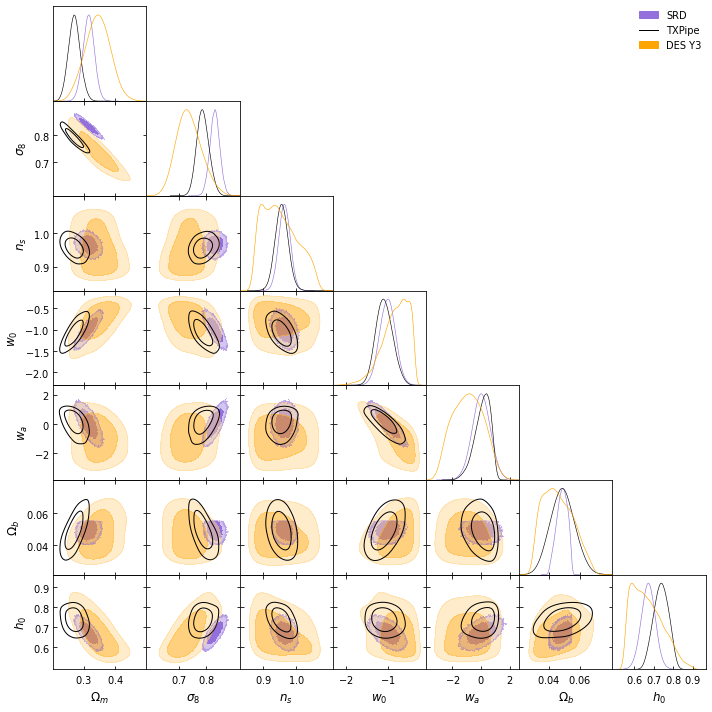

In [48]:
g = plots.getSubplotPlotter(width_inch=10)
g.settings.figure_legend_frame = False
g.settings.axes_fontsize   = 14
g.settings.lab_fontsize    = 16
g.settings.legend_fontsize = 14


cs = ['mediumpurple','k','orange','teal']
g.triangle_plot(Samples, ['Om','sigma8','ns','w0','wa','Ob','h0'],
          filled=[True,False,True,False], colors=cs, alphas=[1.0,1,0.5,0.8,1],
         ls=['-','-', '-', '-'], lws=[1, 1,1,1], 
          legend_labels=["SRD","TXPipe","DES Y3"],          
        legend_loc='upper right', contour_colors=cs)

mplot.savefig('SRDvsTXPipevsDESY3.pdf', bbox_inches='tight')

